<a href="https://colab.research.google.com/github/MadsNL/AMLMain/blob/Flemming/AML_IceCores_best_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! gdown --id 1paSsYReykEVDPX8pA2SUf7Gr7Lptq-PX
! unzip Insoluables_TrainingData26May2022.zip
!git clone https://github.com/MadsNL/AMLpackages.git
import sys
sys.path.append('/content/AMLpackages/')
from load_data import training_set, not_training_set
!pip install pyyaml h5py 
!pip install umap-learn

Streaming af output blev afkortet til de sidste 5000 linjer.
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5532.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5533.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5534.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5535.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5536.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5537.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5538.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5539.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_554.png  
 extracting: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5540.png  
  inflating: Insoluables_TrainingData/train/qsuber/qsub_17nov_1_fc80_20x_5541.png  
  inflating: Ins

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import umap
import seaborn as sb
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [4]:
sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
sup = training_set(sup_df, sup_im_path)

sup_path = '/content/Insoluables_TrainingData/train/'
sup_im_path = '/content/Insoluables_TrainingData/train/'
sup_df = pd.read_csv(sup_path+'train.csv')
train_df, test_df = train_test_split(sup_df, test_size=0.2, random_state = 37)
train = training_set(train_df, sup_im_path)
test = training_set(test_df, sup_im_path)

In [5]:
# save image_size
im_e, lab, feat = sup.__getitem__(147950)
image_size = im_e.shape[0]
image_size

128

In [6]:
train_size = len(train.labels)
test_size = len(test.labels)
print(train_size, test_size)

118368 29592


In [ ]:
latent_dim = 64
image_size= 128
unit_n = 32

encoder_input = keras.Input(shape=(image_size,image_size,1))
x = keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2), activation='relu')(encoder_input)
x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2), activation='relu')(x)
x = keras.layers.Flatten()(x)
encoder_output = keras.layers.Dense(latent_dim)(x)

encoder = keras.Model(encoder_input, encoder_output, name='encoder')

decoder_input = keras.layers.InputLayer(input_shape=latent_dim)(encoder_output)
x = keras.layers.Dense(units=unit_n*unit_n*32, activation=tf.nn.relu)(decoder_input)
x = keras.layers.Reshape(target_shape=(unit_n, unit_n, 32))(x)
x = keras.layers.Conv2DTranspose(
    filters=64, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
x = keras.layers.Conv2DTranspose(
    filters=32, kernel_size=3, strides=2, padding='same',
    activation='relu')(x)
# No activation
decoder_output = keras.layers.Conv2DTranspose(
    filters=1, kernel_size=3, strides=1, padding='same')(x)

autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
autoencoder.summary()

opt = keras.optimizers.Adam(lr=0.001, decay=1e-6)

encoder.compile(opt, loss='mse')
autoencoder.compile(opt, loss='mse')

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 63, 63, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 61504)             0         
                                                                 
 dense (Dense)               (None, 64)                3936320   
                                                                 
 input_2 (InputLayer)        multiple                  0         
                                                                 
 dense_1 (Dense)             (None, 32768)             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

# create encoder training
x_train = []
x_train_lab = []
x_train_feats = []
nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
for i in range(nr_ims):
    im, lab, feat = train.__getitem__(i)
    x_train.append(im)
    x_train_lab.append(lab)
    x_train_feats.append(feat)
x_train = np.array(x_train)
x_train_lab = np.array(x_train_lab)
x_train_feats = np.array(x_train_feats)

#autoencoder.fit(x_train, x_train, epochs=200, batch_size=32, validation_split=0.1, callbacks=[callback])

In [8]:
#encoder.save('encoder')

In [9]:
! gdown --id 1vmtn2HUFFspLehTO-9HNCnphSdiZGez3
! gdown --id 1vOWLDeQh2EEyH2J3VH5XZHhTLqMqAjkV
! gdown --id 1fv_xxclDQrccHZ-T00-cVYHIMFaYjklA
! gdown --id 1NATGxPWVYS71Y-dwPZQvrE7BdsoSpVP8
! unzip autoencoder_128.zip
! unzip encoder_128.zip
! unzip NN_scalar_encoder_128.zip
! unzip NN_last_layer_scalar_encoder_128.zip

encoder = keras.models.load_model('encoder_128')

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1vmtn2HUFFspLehTO-9HNCnphSdiZGez3
To: /content/encoder_128.zip
100% 78.0M/78.0M [00:01<00:00, 41.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1vOWLDeQh2EEyH2J3VH5XZHhTLqMqAjkV
To: /content/autoencoder_128.zip
100% 123M/123M [00:03<00:00, 38.8MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...

In [ ]:
#y_preds = encoder.predict(x_train)
encoder_preds_train = encoder.predict(x_train)

In [ ]:
map = umap.UMAP(n_components=2)
#y = map.fit_transform(y_preds)
y = map.fit_transform(encoder_preds_train)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


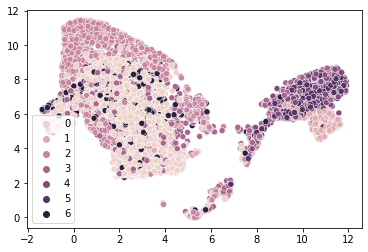

In [ ]:
plt.figure()
sb.scatterplot(x=y[:, 0], y=y[:, 1], hue = x_train_lab)
plt.show()

In [10]:
!pip install scikit-optimize
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 9.8 MB/s 


BEST TREE INCOMING

In [30]:
lgb_model = lgb.LGBMClassifier(objective='multiclass')

Depth      = [1,3,5,7,10,15,20,25,30,35,40,45,50,100]
Learn_rate = [0.01, 0.05, 0.10, 0.2, 2.5, 0.3, 0.4, 0.5, 1]
Estimators = [10,40,70,100,150,200,250,275,300,325,350,400,500]
Leaves     = [1,3,5,7,10,15,20,25,30,35,40,45,50, 70,100,150,200,250,275,300,325,350,400,500]
ites = [1,3,5,7,10,15,20,25,30,35,40,45,50, 70,100,150,200,250,275,300,325,350,400,500]

parameters_Bayesian = {'max_depth'    :Depth,
                       'learning_rate':Learn_rate,
                       'n_estimators' :Estimators,
                       'num_leaves'   :Leaves,
                        }

BayesSearch = BayesSearchCV(lgb_model, 
                          parameters_Bayesian, 
                          cv=5, 
                          return_train_score=True, 
                          refit=True, 
                          n_iter=10
                         );




for i in range(1):
  # create encoder training
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 15000 # 10-15k images are the max we can load with the memory we have
  for i in range(nr_ims):
      im, lab, feat = train.__getitem__(i)
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  BayesSearch.fit(x_train_with_encoded, x_train_lab)


BayesSearch_results = pd.DataFrame(BayesSearch.cv_results_);
print("BayesSearch_results: \tBest parameters: ", BayesSearch.best_params_, f", Best scores: {BayesSearch.best_score_:.4f}\n")

BayesSearch_results: 	Best parameters:  OrderedDict([('learning_rate', 0.3), ('max_depth', 30), ('n_estimators', 350), ('num_leaves', 20)]) , Best scores: 0.8608



In [32]:
best_learn, best_depth, best_esti, best_leaves = BayesSearch.best_params_['learning_rate'], BayesSearch.best_params_['max_depth'], BayesSearch.best_params_['n_estimators'], BayesSearch.best_params_['num_leaves']

best_learn, best_depth, best_esti = 0.3, 15, 250

In [34]:
tree = lgb.LGBMClassifier(objective='multiclass',
                         learning_rate = best_learn,
                          max_depth = best_depth,
                          n_estimators = best_esti,
                          num_leaves = best_leaves)



for i in range(10):
  # create encoder training
  x_train = []
  x_train_lab = []
  x_train_feats = []
  nr_ims = 10000 # 10-15k images are the max we can load with the memory we have
  for i in range(nr_ims):
      im, lab, feat = train.__getitem__(i)
      x_train.append(im)
      x_train_lab.append(lab)
      x_train_feats.append(feat)
  x_train = np.array(x_train)
  x_train_lab = np.array(x_train_lab)
  x_train_feats = np.array(x_train_feats)

  y_preds = encoder.predict(x_train)

  x_train_with_encoded = []
  for i in range(len(y_preds)):
      inp = np.append(x_train_feats[i], y_preds[i])
      x_train_with_encoded.append(inp)
  x_train_with_encoded = np.array(x_train_with_encoded)
  
  tree.fit(x_train_with_encoded, x_train_lab)


# load the model
#model = pickle.load(open("tree_model_trained.pkl.pkl", "rb"))

In [35]:
import pickle
pickle.dump(tree, open("tree_model_trained.pkl", "wb"))
#tree = pickle.load(open("AMLpackages/tree_model_trained.pkl", "rb"))

In [37]:
#tree = pickle.load(open("AMLpackages/tree_model_trained.pkl", "rb"))


# create testing
tree_encoder_preds_test_preds = ([])
x_test_labs = ([])
for i in range(5):
  x_test = []
  x_test_lab = []
  x_test_feats = []
  nr_ims = 5000
  for i in range(nr_ims):
      im, lab, feat = test.__getitem__(i)
      x_test.append(im)
      x_test_lab.append(lab)
      x_test_labs.append(lab)
      x_test_feats.append(feat)
  x_test = np.array(x_test)
  x_test_lab = np.array(x_test_lab)
  x_test_feats = np.array(x_test_feats)

  encoder_preds_test = encoder.predict(x_test)
  #tree_encoder_preds_test = tree.predict(encoder_preds_test)
  scalar_encoder_combined_test = []
  for i in range(len(x_test_feats)):
      comb = np.append(x_test_feats[i], encoder_preds_test[i])
      scalar_encoder_combined_test.append(comb)
  scalar_encoder_combined_test = np.array(scalar_encoder_combined_test)

  tree_encoder_preds_test = tree.predict(scalar_encoder_combined_test)
  tree_encoder_preds_test_preds.append(tree_encoder_preds_test)

x_test_labs = np.array(x_test_labs)
x_test_labs.resize((1, 25000))
x_test_labs = x_test_labs[0]

tree_encoder_preds_test_preds = np.array(tree_encoder_preds_test_preds)
tree_encoder_preds_test_preds.resize((1, 25000))
tree_encoder_preds_test_preds = list(tree_encoder_preds_test_preds[0])

acc_encoder = sum(tree_encoder_preds_test_preds==x_test_labs)/len(x_test_labs)
acc_encoder

0.8642

# Making Confusing Matrix

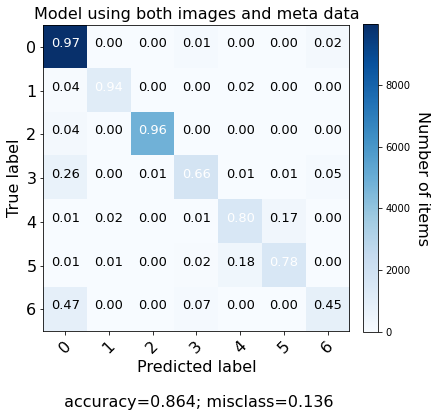

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Confusion matrix function
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          savefig = ''):

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=16)
        plt.yticks(tick_marks, target_names, fontsize=16)
        

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=13,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=16,
                     color="white" if cm[i, j] > thresh else "black")


    #plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel(f'Predicted label\n\n accuracy={accuracy:0.3f}; misclass={misclass:0.3f}', fontsize=16)
    cbar.ax.set_ylabel('Number of items',  labelpad=20, rotation=270, fontsize=16)   
    
    
    if savefig: plt.savefig(savefig, bbox_inches='tight')
    
    plt.show()

from sklearn.metrics import confusion_matrix
cm_both = confusion_matrix(x_test_labs, tree_encoder_preds_test_preds)

plot_confusion_matrix(cm_both, target_names=['0', '1', '2', '3', '4', '5', '6',], title="Model using both images and meta data", normalize=True, savefig='')

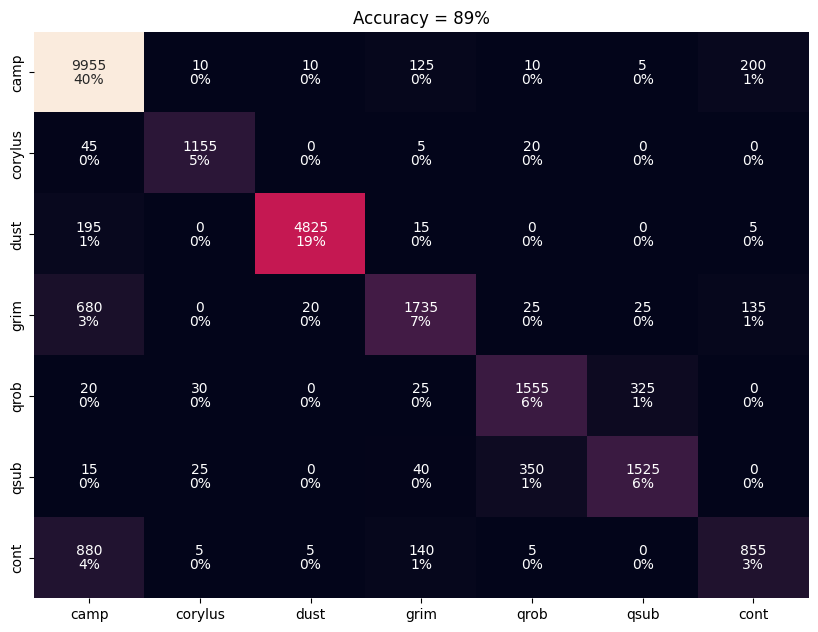

In [ ]:
cm = confusion_matrix(x_test_labs, tree_encoder_preds_test_preds)
cm_perc = cm/np.sum(cm)
types = ['camp', 'corylus', 'dust', 'grim', 'qrob', 'qsub', 'cont']

plt.figure(figsize=(10,7.5),dpi=100)
plt.title('Accuracy = 89%')
sb.heatmap(cm, annot=False, cbar=False, xticklabels=types, yticklabels=types)
sb.heatmap(cm, annot=True, annot_kws={'va':'bottom'}, fmt="", cbar=False, xticklabels=types, yticklabels=types)
sb.heatmap(cm, annot=cm_perc, annot_kws={'va':'top'}, fmt=".0%", cbar=False, xticklabels=types, yticklabels=types)
plt.savefig('scalar_encoder_128_confusion.png')